In [1]:
import numpy as np
import scipy as sc
import os
import math
import cv2
import matplotlib.pyplot as plt
import dlib
from numpy.linalg import svd, inv
from scipy.spatial import ConvexHull
import scipy as sp
import scipy.sparse.linalg
from skimage import draw
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
%matplotlib inline

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


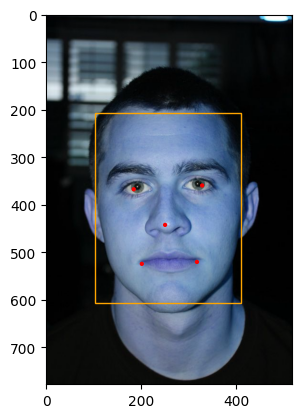

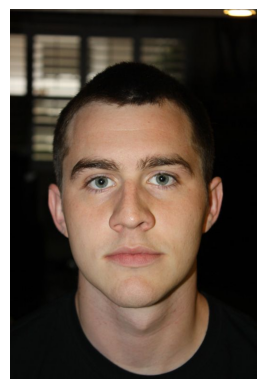

In [2]:
import cv2
import mtcnn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

def move_mouth_down(image, mouth_left, mouth_right, move_factor, background):
    # Copy the original image to avoid modifying the original
    modified_image = image.copy()

    # Estimate the position of the upper and lower lip based on the left and right corners of the mouth
    mouth_top = ((mouth_left[0] + mouth_right[0]) // 2, (mouth_left[1] + mouth_right[1]) // 2 - move_factor)
    mouth_bottom = ((mouth_left[0] + mouth_right[0]) // 2, (mouth_left[1] + mouth_right[1]) // 2 + move_factor)

    # Create a mask for the modified mouth area
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    points = np.array([mouth_left, mouth_right, mouth_top, mouth_bottom], dtype=np.int32)
    cv2.fillPoly(mask, [points], (255, 255, 255))

    # Perform Poisson blending to blend the modified mouth area with the background
    result = cv2.seamlessClone(modified_image, background, mask, ((mouth_left[0] + mouth_right[0]) // 2, (mouth_left[1] + mouth_right[1]) // 2), cv2.NORMAL_CLONE)

    return result

def draw_facebox(image, result_list):
    plt.imshow(image)
    ax = plt.gca()
    for result in result_list:
        x, y, width, height = result['box']
        rect = Rectangle((x, y), width, height, fill=False, color='orange')
        ax.add_patch(rect)
        for key, value in result['keypoints'].items():
            dot = Circle(value, radius=3, color='red')
            ax.add_patch(dot)
    plt.show()

# Load image
filename = "sources/image.jpeg"
image = cv2.imread(filename)

# Detect faces
detector = mtcnn.MTCNN()
faces = detector.detect_faces(image)

# Draw bounding boxes and keypoints on the original image
draw_facebox(image, faces)

# Modify the image by moving the mouth points down
move_factor = 50  # Adjust as needed
background = cv2.imread(filename)  # Assuming background is the same image
for result in faces:
    mouth_left = result['keypoints']['mouth_left']
    mouth_right = result['keypoints']['mouth_right']
    modified_image = move_mouth_down(image, mouth_left, mouth_right, move_factor, background)
    
    # Show the modified image
    plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [3]:
def align_source(object_img, mask, background_img, bottom_center):
    ys, xs = np.where(mask == 1)
    (h,w,_) = object_img.shape
    y1 = x1 = 0
    y2, x2 = h, w
    object_img2 = np.zeros(background_img.shape)
    yind = np.arange(y1,y2)
    yind2 = yind - int(max(ys)) + bottom_center[1]
    xind = np.arange(x1,x2)
    xind2 = xind - int(round(np.mean(xs))) + bottom_center[0]

    ys = ys - int(max(ys)) + bottom_center[1]
    xs = xs - int(round(np.mean(xs))) + bottom_center[0]
    mask2 = np.zeros(background_img.shape[:2], dtype=bool)
    for i in range(len(xs)):
        mask2[int(ys[i]), int(xs[i])] = True
    for i in range(len(yind)):
        for j in range(len(xind)):
            object_img2[yind2[i], xind2[j], :] = object_img[yind[i], xind[j], :]
    mask3 = np.zeros([mask2.shape[0], mask2.shape[1], 3])
    for i in range(3):
        mask3[:,:, i] = mask2
    background_img  = object_img2 * mask3 + (1-mask3) * background_img
    # plt.figure()
    # plt.imshow(background_img)
    return object_img2, mask2

In [4]:
def upper_left_background_rc(object_mask, bottom_center):
    """ 
      Returns upper-left (row,col) coordinate in background image that corresponds to (0,0) in the object image
      object_mask: foreground mask in object image
      bottom_center: bottom-center (x=col, y=row) position of foreground object in background image
    """
    ys, xs = np.where(object_mask == 1)
    (h,w) = object_mask.shape[:2]
    upper_left_row = bottom_center[1]-int(max(ys)) 
    upper_left_col = bottom_center[0] - int(round(np.mean(xs)))
    return [upper_left_row, upper_left_col]

In [5]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool_)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [6]:

def crop_object_img(object_img, object_mask):
    ys, xs = np.where(object_mask == 1)
    (h,w) = object_mask.shape[:2]
    x1 = min(xs)-1
    x2 = max(xs)+1
    y1 = min(ys)-1
    y2 = max(ys)+1
    object_mask = object_mask[y1:y2+1, x1:x2+1]
    object_img = object_img[y1:y2+1, x1:x2+1, :]
    return object_img, object_mask

def get_combined_img(bg_img, object_img, object_mask, bg_ul):
    combined_img = bg_img.copy()
    (nr, nc) = object_img.shape[:2]

    for b in np.arange(object_img.shape[2]):
      combined_patch = combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc, b]
      combined_patch = combined_patch*(1-object_mask) + object_img[:,:,b]*object_mask
      combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc, b] =  combined_patch

    return combined_img 

In [7]:

def get_mask(ys, xs, img):
    mask = poly2mask(ys, xs, img.shape[:2]).astype(int)
    fig = plt.figure()
    plt.imshow(mask, cmap='gray')
    return mask

In [8]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param bg_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    m, blur, coords = np.tile(object_mask[:, :, None], 3), np.copy(bg_img) * 0, np.argwhere(object_mask)
    lis = [tuple(coord) for coord in coords]
    n = len(lis)
    vals = {coord: idx for idx, coord in enumerate(lis)}
    A, idx = sp.sparse.lil_matrix((len(lis) * 4, n), dtype='double'), 0
    
    for x, y in lis:
        for dx, dy in [(1,0), (-1, 0), (0, 1), (0, -1)]:
            newx, newy = x + dx, y + dy
            A[idx, vals[(x,y)]] += 1
            val_keys = vals.keys()
            if (newx, newy) in val_keys:
                A[idx, vals[(newx, newy)]] += -1
            idx += 1
    A = sp.sparse.csr_matrix(A)
    
    for i in range(3):
        b, newidx = np.zeros((len(lis)*4), dtype='double'), 0
        for x, y in lis:
            for dx, dy in [(1,0), (-1, 0), (0, 1), (0, -1)]:
                newx, newy = x + dx, y + dy
                b[newidx] = object_img[x][y][i] - object_img[newx][newy][i]
                val_keys = vals.keys()
                if (newx, newy) not in val_keys:
                    b[newidx] += bg_img[newx][newy][i]
                newidx += 1

        final = sp.sparse.linalg.lsqr(A, b, atol=5**-40, btol=5**-40)[0].clip(0, 1)
        for (y, x), index in vals.items():
            blur[y, x, i] += final[index]
    add_to_blur = (bg_img)*(1-m)
    
    return blur + add_to_blur

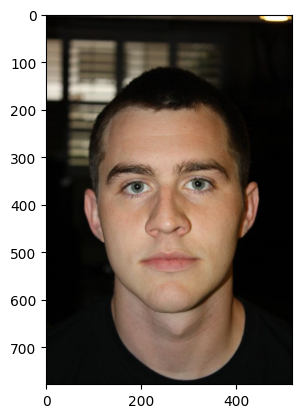

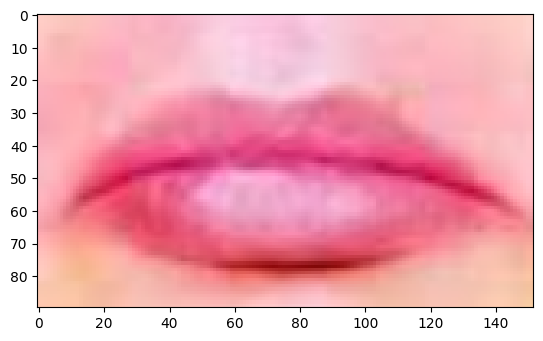

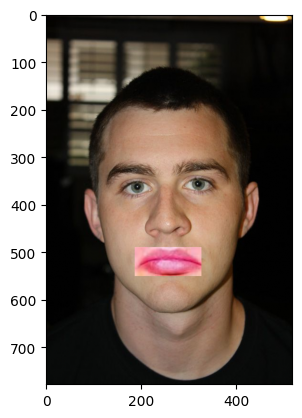

In [9]:
background_img = cv2.cvtColor(cv2.imread('sources/image.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
height, width = background_img.shape[:2]
# new_width = int(width*1/4)
# new_height = int(height*1/4)
# background_img = cv2.resize(background_img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(background_img)
plt.show()

object_img = cv2.cvtColor(cv2.imread('sources/sad.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
height, width = object_img.shape[:2]
new_width = int(width*1/2)
new_height = int(height*1/2)
object_img = cv2.resize(object_img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
 
  xs = (1, 140, 140, 1)
  ys = (20, 20, 80, 80)
  mask = get_mask(ys, xs, object_img)
  bottom_center = (255, 550)
  object_img, object_mask = crop_object_img(object_img, mask)
  bg_ul = upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(get_combined_img(background_img, object_img, object_mask, bg_ul))

In [10]:
object_img, object_mask = align_source(object_img, object_mask, background_img, bottom_center)

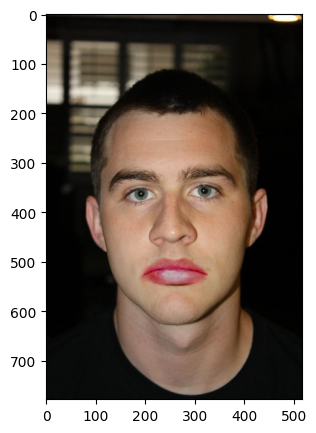

In [11]:
im_blend = poisson_blend(object_img, object_mask, background_img, bg_ul)
plt.figure(figsize=(5,5))
plt.imshow(im_blend)